In [1]:
%matplotlib inline
import os

import cftime

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

# NOTE: issues in esmlab are being actively fixed, so using local install instead of release version
import esmlab

import intake
# NOTE: installed locally to fix occasional bugs
import intake_esm

In [2]:
cesm2 = intake.open_esm_datastore('/glade/work/mlevy/intake-esm-collection/json/CESM2-CMIP6_only-NOT_CMORIZED.json')
cesm2.df.head()

,experiment,case,component,stream,variable,date_range,member_id,path,ctrl_branch_year
0,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,TREFHTMN,00010101-00101231,0,/glade/campaign/collections/cmip/CMIP6/timeser...,501
1,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,TREFHTMN,00110101-00201231,0,/glade/campaign/collections/cmip/CMIP6/timeser...,501
2,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,TREFHTMN,00210101-00301231,0,/glade/campaign/collections/cmip/CMIP6/timeser...,501
3,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,TREFHTMN,00310101-00401231,0,/glade/campaign/collections/cmip/CMIP6/timeser...,501
4,esm-piControl,b.e21.B1850.f09_g17.CMIP6-esm-piControl.001,atm,cam.h1,TREFHTMN,00410101-00501231,0,/glade/campaign/collections/cmip/CMIP6/timeser...,501


In [3]:
cesm2.df.columns

Index(['experiment', 'case', 'component', 'stream', 'variable', 'date_range',
       'member_id', 'path', 'ctrl_branch_year'],
      dtype='object')

In [4]:
### TODO: SUPPORT CMIP5
cesm1 = intake.open_esm_datastore('/glade/work/mlevy/intake-esm-collection/json/CESM1-CMIP5_only-NOT_CMORIZED.json')
cesm1.df.head()

,experiment,case,component,stream,variable,date_range,member_id,path,ctrl_branch_year
0,1pctCO2-rad,b40.1850_ramp.1deg.ncbcrd.002,ocn,pop.h,IRON_FLUX,000101-014012,0,/glade/p/cgd/oce/projects/cesm2-marbl/intake-e...,151
1,1pctCO2-bgc,b40.1850_ramp.1deg.ncbdrc.001,ocn,pop.h,IRON_FLUX,000101-014012,0,/glade/p/cgd/oce/projects/cesm2-marbl/intake-e...,151
2,1pctCO2,b40.1850_ramp.1deg.ncbdrd.001,ocn,pop.h,IRON_FLUX,000101-014012,0,/glade/p/cgd/oce/projects/cesm2-marbl/intake-e...,151
3,historical,b40.20th.1deg.bdrd.001,ocn,pop.h,IRON_FLUX,185001-200512,0,/glade/p/cgd/oce/projects/cesm2-marbl/intake-e...,151
4,esm-hist,b40.20th.1deg.coup.001,ocn,pop.h,IRON_FLUX,185001-200512,0,/glade/p/cgd/oce/projects/cesm2-marbl/intake-e...,351


In [5]:
keep_vars = ['TAREA', 'TLONG', 'TLAT', 'IRON_FLUX', 'time', 'time_bound', 'member_id']

In [6]:
dq_tmp = cesm2.search(experiment=['historical'], variable='IRON_FLUX')

# WORKAROUND DUE TO BAD DATA ON CAMPAIGN
df = dq_tmp.df.copy()
dq_tmp.df = df[~df.date_range.isin(['185002-190001', '190002-195001', '195002-200001', '200002-201412'])]

dq = dq_tmp.to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})


_, ds2 = dq.popitem()
print("Initial dataset size: {} GB".format(ds2.nbytes/(1024**3)))
ds2 = ds2.drop([v for v in ds2.variables if v not in keep_vars])
print("Reduced dataset size: {} GB".format(ds2.nbytes/(1024**3)))
print(ds2)

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)
Initial dataset size: 40.798875737935305 GB
Reduced dataset size: 11.784712307155132 GB
<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 11, nlat: 384, nlon: 320, time: 1980)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time        (time) object 1850-02-01 00:00:00 ... 2015-01-01 00:00:00
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(48, 2), meta=np.ndarray>
    TAREA       (time, nlat, nlon) float64 dask.array<chunksize=(1980, 384, 320), meta=np.ndarray>
    IRON_FLUX   (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 48, 384, 320), meta=np.ndarray>
Attribut

In [7]:
dq = cesm1.search(experiment='historical', variable='IRON_FLUX').to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})
_, ds1 = dq.popitem()
ds1 = ds1.drop([v for v in ds1.variables if v not in keep_vars])
ds1

--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream'

--> There will be 1 group(s)


<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 1, nlat: 384, nlon: 320, time: 1872)
Coordinates:
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time        (time) object 1850-02-01 00:00:00 ... 2006-01-01 00:00:00
  * member_id   (member_id) int64 0
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object dask.array<chunksize=(48, 2), meta=np.ndarray>
    TAREA       (time, nlat, nlon) float64 dask.array<chunksize=(1872, 384, 320), meta=np.ndarray>
    IRON_FLUX   (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 48, 384, 320), meta=np.ndarray>
Attributes:
    title:                     b40.20th.1deg.bdrd.001
    history:                   Sat Dec 17 19:11:26 2011: /usr/local/bin/ncrca...
    conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    contents:                  D

In [8]:
ds2_ann = esmlab.resample(ds2, freq='ann')
ds2_ann

<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 11, nlat: 384, nlon: 320, time: 165)
Coordinates:
  * member_id   (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * time        (time) object 1850-07-01 17:05:00 ... 2014-07-01 17:00:00
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (d2, time) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    TAREA       (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    IRON_FLUX   (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
Attributes:
    history:  \n2019-11-07 15:27:53.968926 esmlab.resample(<DATASET>, freq="a...

In [9]:
ds1_ann = esmlab.resample(ds1, freq='ann')
ds1_ann

<xarray.Dataset>
Dimensions:     (d2: 2, member_id: 1, nlat: 384, nlon: 320, time: 156)
Coordinates:
  * member_id   (member_id) int64 0
  * time        (time) object 1850-07-01 18:02:30 ... 2005-07-01 17:00:00
    TLAT        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG       (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (d2, time) object 1850-01-02 01:00:00 ... 2006-01-01 00:00:00
    TAREA       (time, nlat, nlon) float64 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    IRON_FLUX   (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 1, 384, 320), meta=np.ndarray>
Attributes:
    history:  \n2019-11-07 15:27:57.826334 esmlab.resample(<DATASET>, freq="a...

In [10]:
iron_flux_glb2 = esmlab.weighted_sum(ds2_ann.IRON_FLUX, dim=['nlat', 'nlon'], weights=ds2_ann.TAREA)
iron_flux_glb2 = iron_flux_glb2 * 1.0e-16 * 365.0 * 86400.0 # mmolFe/m^2/s to GmolFe/y
iron_flux_glb2.attrs['units'] = 'Gmol Fe yr$^{-1}$'
iron_flux_glb2 = iron_flux_glb2.compute()
iron_flux_glb2

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (member_id: 11, time: 165)>
array([[9.2300802 , 8.26259593, 8.22607918, ..., 8.87160024, 8.82485228,
        8.11518775],
       [8.32685797, 7.26389874, 8.52567667, ..., 8.69017733, 9.25795746,
        8.37191988],
       [8.1106605 , 8.38003757, 8.23106228, ..., 7.89537625, 8.13547233,
        8.61778304],
       ...,
       [7.61386383, 7.59802859, 8.1020224 , ..., 8.35342317, 8.31701001,
        7.52157364],
       [8.81659523, 7.76057121, 8.21183624, ..., 8.43592903, 7.45949937,
        9.3636691 ],
       [8.24144115, 9.43141237, 9.26289287, ..., 8.58407975, 7.95796275,
        8.55384729]])
Coordinates:
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 10 11
  * time       (time) object 1850-07-01 17:05:00 ... 2014-07-01 17:00:00
Attributes:
    units:    Gmol Fe yr$^{-1}$

In [11]:
iron_flux_glb1 = esmlab.weighted_sum(ds1_ann.IRON_FLUX, dim=['nlat', 'nlon'], weights=ds1_ann.TAREA)
iron_flux_glb1 = iron_flux_glb1 * 1.0e-16 * 365.0 * 86400.0 # mmolFe/m^2/s to GmolFe/y
iron_flux_glb1.attrs['units'] = 'Gmol Fe yr$^{-1}$'
iron_flux_glb1 = iron_flux_glb1.compute()
iron_flux_glb1

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray (member_id: 1, time: 156)>
array([[6.61582808, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
        6.61378312, 6.61378312, 6.61378312, 6.61378312, 6.61378312,
   

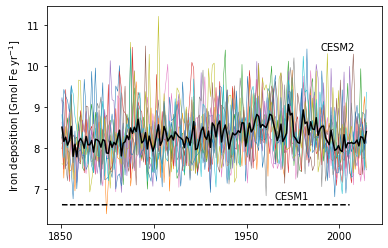

In [12]:
plot_name = f'timeseries.global.IRON_FLUX.pdf'

fig = plt.figure()
ax = fig.add_subplot(111)
for i in iron_flux_glb2.member_id.values:
    ax.plot(iron_flux_glb2.time, iron_flux_glb2.sel(member_id=i), linewidth=0.5)

ax.plot(iron_flux_glb2.time, iron_flux_glb2.mean('member_id'), color='k', linewidth=1.5)    

ax.plot(iron_flux_glb1.time, iron_flux_glb1.isel(member_id=0), linestyle='--', color='k', linewidth=1.5)    

ax.set_ylabel('Iron deposition [Gmol Fe yr$^{-1}$]');

ax.text(cftime.DatetimeNoLeap(1990, 1, 1), iron_flux_glb2.sel(time='1990').max('member_id')*1.05, 'CESM2',color='k');

ax.text(cftime.DatetimeNoLeap(1965, 1, 1), iron_flux_glb1.sel(time='1960')*1.02, 'CESM1',color='k');

#plt.savefig(plot_name,dpi=300,bbox_inches='tight')

In [13]:
mmolm2s_to_molm2yr = 1e-3 * 86400. * 365.
iron_flux_map2 = ds2_ann.IRON_FLUX.sel(time=slice('1995', '2014')).mean(['time', 'member_id'])
iron_flux_map2 = iron_flux_map2.compute() * mmolm2s_to_molm2yr
iron_flux_map2

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'IRON_FLUX' (nlat: 384, nlon: 320)>
array([[           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [4.01281948e-08, 3.76392364e-08, 3.66805627e-08, ...,
                   nan,            nan,            nan],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
Dimensions without coordinates: nlat, nlon

/glade/work/mlevy/miniconda3/envs/cesm2-marbl/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


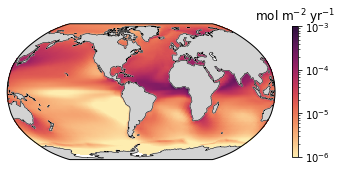

In [14]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))


pc = ax.pcolormesh(ds2.TLONG, ds2.TLAT, iron_flux_map2,
                   norm=colors.LogNorm(vmin=1e-6, vmax=1e-3),
                   cmap=cmocean.cm.matter,
                   transform=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m',
                                                   edgecolor='face',
                                                   facecolor='lightgray'))
ax.set_global() 
ax.coastlines(linewidth=0.5)
cb = plt.colorbar(pc, shrink=0.6)
cb.ax.set_title('mol m$^{-2}$ yr$^{-1}$');

In [15]:
iron_flux_map2.max()

<xarray.DataArray 'IRON_FLUX' ()>
array(0.00104972)

In [16]:
# TODO: Matt mentioned extending time series plot to 2100
dq_tmp = cesm2.search(experiment=['historical', 'SSP5-8.5'], variable='IRON_FLUX')

dq_tmp.df
# NOTE THE ADDITIONAL BAD DATES IN THE SSP5-8.5 EXPERIMENTS!!!!

# # WORKAROUND DUE TO BAD DATA ON CAMPAIGN
# df = dq_tmp.df.copy()
# dq_tmp.df = df[~df.date_range.isin(['185002-190001', '190002-195001', '195002-200001', '200002-201412', '206501-209012', '206501-209512'])]

# dq = dq_tmp.to_dataset_dict(cdf_kwargs={'chunks':{'time': 48}})

# dq

,experiment,case,component,stream,variable,date_range,member_id,path,ctrl_branch_year
116290,historical,b.e21.BHIST.f09_g17.CMIP6-historical.001,ocn,pop.h,IRON_FLUX,185001-201412,1,/glade/campaign/collections/cmip/CMIP6/timeser...,601
119452,historical,b.e21.BHIST.f09_g17.CMIP6-historical.002,ocn,pop.h,IRON_FLUX,185001-201412,2,/glade/campaign/collections/cmip/CMIP6/timeser...,631
122614,historical,b.e21.BHIST.f09_g17.CMIP6-historical.003,ocn,pop.h,IRON_FLUX,185001-201412,3,/glade/campaign/collections/cmip/CMIP6/timeser...,661
125776,historical,b.e21.BHIST.f09_g17.CMIP6-historical.004,ocn,pop.h,IRON_FLUX,185001-201412,4,/glade/campaign/collections/cmip/CMIP6/timeser...,501
129262,historical,b.e21.BHIST.f09_g17.CMIP6-historical.005,ocn,pop.h,IRON_FLUX,185001-201412,5,/glade/campaign/collections/cmip/CMIP6/timeser...,691
132747,historical,b.e21.BHIST.f09_g17.CMIP6-historical.006,ocn,pop.h,IRON_FLUX,185001-201412,6,/glade/campaign/collections/cmip/CMIP6/timeser...,721
145951,historical,b.e21.BHIST.f09_g17.CMIP6-historical.007,ocn,pop.h,IRON_FLUX,185001-189912,7,/glade/campaign/collections/cmip/CMIP6/timeser...,751
145952,historical,b.e21.BHIST.f09_g17.CMIP6-historical.007,ocn,pop.h,IRON_FLUX,185002-190001,7,/glade/campaign/collections/cmip/CMIP6/timeser...,751
145953,historical,b.e21.BHIST.f09_g17.CMIP6-historical.007,ocn,pop.h,IRON_FLUX,190001-194912,7,/glade/campaign/collections/cmip/CMIP6/timeser...,751
145954,historical,b.e21.BHIST.f09_g17.CMIP6-historical.007,ocn,pop.h,IRON_FLUX,190002-195001,7,/glade/campaign/collections/cmip/CMIP6/timeser...,751
